# CLIP + DenseNet Fusion for APTOS 2019

Colab-ready notebook: CLIP (HuggingFace) + DenseNet121 fusion for diabetic retinopathy grading on the APTOS2019 dataset.

**Contents:**

1. Install dependencies
2. (Optional) Download APTOS via Kaggle
3. Data loader & preprocessing
4. CLIP + DenseNet fusion model
5. Linear-probe training -> Fine-tuning
6. Evaluation & metrics
7. Grad-CAM visualizations

Run cell-by-cell in Colab. Upload `train.csv` and `train_images/` to `/content` or place `kaggle.json` to enable Kaggle download.


This notebook demonstrates how to fuse CLIP and DenseNet models for diabetic retinopathy grading on the APTOS2019 dataset. The process involves installing necessary libraries, downloading and preparing the dataset, defining the fusion model, training the model in two stages (linear probing and fine-tuning), evaluating the performance, and visualizing results using Grad-CAM.

## 1. Install dependencies

This cell installs all the required Python packages for the notebook, including PyTorch, Torchvision, HuggingFace Transformers, Timm, PyTorch Lightning, Scikit-learn, Pandas, OpenCV, Pillow, Grad-CAM, Albumentations, and Kaggle.

In [7]:
# Install correct PyTorch + Torchvision for Colab
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Other required libraries
!pip install -q transformers timm pytorch-lightning scikit-learn pandas opencv-python pillow grad-cam albumentations kaggle tqdm

## 2. (Optional) Download APTOS via Kaggle

This cell uses the Kaggle API to download the APTOS2019 dataset. Make sure you have your `kaggle.json` file in the correct location (`/root/.kaggle/kaggle.json`) for this to work. The code then prints the dataset location and identifies the directories containing images.

In [8]:
# Download APTOS Dataset
import os
import kagglehub

# Download the dataset using kagglehub
path = kagglehub.dataset_download("mariaherrerot/aptos2019")
print("Dataset location:", path)

# Walk through the downloaded directory to find image folders
for root, dirs, files in os.walk(path):
    if any(fname.endswith('.png') for fname in files):
        print("Image folder found:", root)

Dataset location: /root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3
Image folder found: /root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3/val_images/val_images
Image folder found: /root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3/test_images/test_images
Image folder found: /root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3/train_images/train_images


These cells load the training and validation dataframes from the downloaded dataset using `kagglehub.load_dataset`. The `DeprecationWarning` indicates that `load_dataset` will be replaced by `dataset_load` in future versions of `kagglehub`.

This cell defines the paths to the training and test image directories. **Note:** These paths are hardcoded and might need to be adjusted based on where the dataset is extracted. Later in the notebook, the actual image directory is located dynamically.

This cell imports all the necessary libraries for the rest of the notebook, including PyTorch, PIL, NumPy, Pandas, Torchvision transforms, HuggingFace Transformers (for CLIP), Scikit-learn (for metrics), and Matplotlib.

In [9]:
# Import Required Libraries
import random
import math
from pathlib import Path
from PIL import Image
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision import models
from transformers import CLIPProcessor, CLIPModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
from tqdm import tqdm

print(' Libraries imported')

 Libraries imported


## 3. Data loader & preprocessing

This cell defines a custom `AptosDataset` class that inherits from `torch.utils.data.Dataset`. This class is responsible for loading images and their corresponding labels from the dataframe and applying the specified transformations. It also includes a `collate_fn` to handle batching of data for the DataLoader.

This cell loads the `train_1.csv` file into a pandas DataFrame, splits it into training and validation sets using `train_test_split`, and dynamically finds the actual directory containing the image files within the downloaded dataset path.

In [10]:
# Load and Split Dataset
# Search for train_1.csv within the downloaded dataset path
TRAIN_CSV_NAME = 'train_1.csv'
TRAIN_CSV = None
for root, dirs, files in os.walk(path):
    if TRAIN_CSV_NAME in files:
        TRAIN_CSV = os.path.join(root, TRAIN_CSV_NAME)
        break

if not TRAIN_CSV or not os.path.exists(TRAIN_CSV):
    raise FileNotFoundError(f'{TRAIN_CSV_NAME} not found in the dataset path {path} or its subdirectories.')

# Load the training data into a pandas DataFrame
df = pd.read_csv(TRAIN_CSV)
print('Loaded train_1.csv with', len(df), 'rows')
print('Class distribution:\n', df['diagnosis'].value_counts().sort_index())

# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.15, stratify=df['diagnosis'], random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print('Train / Val sizes:', len(train_df), len(val_df))

# Find ALL image directories in the dataset
IMAGE_DIRS = []
for root, dirs, files in os.walk(path):
    if any(fname.endswith(('.png', '.jpg', '.jpeg')) for fname in files):
        IMAGE_DIRS.append(root)
        print(f"Found image directory: {root}")

if not IMAGE_DIRS:
    raise FileNotFoundError(f'No image directories found in {path}')

print(f"\nTotal image directories found: {len(IMAGE_DIRS)}")

Loaded train_1.csv with 2930 rows
Class distribution:
 diagnosis
0    1434
1     300
2     808
3     154
4     234
Name: count, dtype: int64
Train / Val sizes: 2490 440
Found image directory: /root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3/val_images/val_images
Found image directory: /root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3/test_images/test_images
Found image directory: /root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3/train_images/train_images

Total image directories found: 3


In [11]:
class AptosDataset(Dataset):
    def __init__(self, df, image_dirs, clip_processor, transform_cnn=None, transform_clip=None):
        """
        Fixed dataset class that searches multiple directories

        Args:
            df: DataFrame with 'id_code' and 'diagnosis' columns
            image_dirs: List of directories to search for images
            clip_processor: CLIP processor for image preprocessing
            transform_cnn: Transforms for CNN model
            transform_clip: Transforms for CLIP model
        """
        self.df = df.reset_index(drop=True)
        self.image_dirs = [Path(d) for d in image_dirs]
        self.clip_processor = clip_processor
        self.transform_cnn = transform_cnn
        self.transform_clip = transform_clip

        # Build image path cache for faster lookup
        self.image_cache = {}
        print(f" Building image cache for {len(self.df)} samples...")
        missing_images = []

        for idx in range(len(self.df)):
            img_id = self.df.iloc[idx]['id_code']
            found = False

            # Search in all image directories
            for img_dir in self.image_dirs:
                for ext in ['png', 'jpg', 'jpeg']:
                    img_path = img_dir / f"{img_id}.{ext}"
                    if img_path.exists():
                        self.image_cache[img_id] = img_path
                        found = True
                        break
                if found:
                    break

            if not found:
                missing_images.append(img_id)

        if missing_images:
            print(f" WARNING: {len(missing_images)} images not found out of {len(self.df)}")
            print(f"First 10 missing: {missing_images[:10]}")
            # Remove missing images from dataframe
            self.df = self.df[~self.df['id_code'].isin(missing_images)].reset_index(drop=True)
            print(f" Continuing with {len(self.df)} valid images")
        else:
            print(f" All {len(self.df)} images found successfully!")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row['id_code']
        label = int(row['diagnosis'])

        # Get image path from cache
        if img_id not in self.image_cache:
            raise FileNotFoundError(f'Image for {img_id} not found')

        img_path = self.image_cache[img_id]
        img = Image.open(img_path).convert('RGB')

        # Apply CNN transforms
        if self.transform_cnn is not None:
            img_cnn = self.transform_cnn(img)
        else:
            img_cnn = T.ToTensor()(img)

        # For CLIP, return PIL image
        if self.transform_clip is not None:
            img_clip = self.transform_clip(img)
        else:
            img_clip = img

        return img_cnn, img_clip, label, img_id


def collate_fn(batch, clip_processor, device):
    """Custom collate function to handle CLIP preprocessing"""
    imgs_cnn = torch.stack([b[0] for b in batch])
    imgs_pil = [b[1] for b in batch]
    labels = torch.tensor([b[2] for b in batch], dtype=torch.long)
    ids = [b[3] for b in batch]

    # Process images for CLIP
    clip_inputs = clip_processor(images=imgs_pil, return_tensors='pt')
    pixel_values = clip_inputs['pixel_values']

    return imgs_cnn.to(device), pixel_values.to(device), labels.to(device), ids

print(' Fixed Dataset class defined')

 Fixed Dataset class defined


This cell sets the device for training (GPU if available, otherwise CPU), defines image transformations for the CNN and CLIP models, initializes the CLIP processor, creates instances of the `AptosDataset` for training and validation, and finally creates DataLoaders for iterating over the datasets in batches.

In [12]:
# Setup Device and Transforms
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')


# Define image transformations for the CNN
size = 512
transform_cnn = T.Compose([
    T.Resize((size, size)),
    T.RandomRotation(15),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_cnn_val = T.Compose([
    T.Resize((size, size)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the CLIP processor
clip_model_name = 'openai/clip-vit-base-patch32'
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

# Create dataset instances for training and validation
# Pass the list of image directories (IMAGE_DIRS) to AptosDataset
train_ds = AptosDataset(train_df, IMAGE_DIRS, clip_processor, transform_cnn=transform_cnn, transform_clip=None)
val_ds = AptosDataset(val_df, IMAGE_DIRS, clip_processor, transform_cnn=transform_cnn_val, transform_clip=None)

# Create DataLoaders for training and validation
batch_size = 8
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda b: collate_fn(b, clip_processor, device),
    num_workers=0 # Set num_workers to 0 to avoid CUDA re-initialization issue in subprocesses
)
val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda b: collate_fn(b, clip_processor, device),
    num_workers=0 # Set num_workers to 0 to avoid CUDA re-initialization issue in subprocesses
)

print('DataLoaders ready - batches per epoch (train, val):', len(train_loader), len(val_loader))

# Test the DataLoader
print("\n🧪 Testing DataLoader...")
try:
    test_batch = next(iter(train_loader))
    imgs_cnn, pixel_values, labels, ids = test_batch
    print(f" DataLoader test PASSED!")
    print(f"   - Batch CNN images shape: {imgs_cnn.shape}")
    print(f"   - Batch CLIP pixels shape: {pixel_values.shape}")
    print(f"   - Labels: {labels.tolist()}")
    print(f"   - IDs: {ids[:3]}...")
except Exception as e:
    print(f" DataLoader test FAILED: {e}")
    raise

Device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB
 Building image cache for 2490 samples...
 All 2490 images found successfully!
 Building image cache for 440 samples...
 All 440 images found successfully!
DataLoaders ready - batches per epoch (train, val): 312 55

🧪 Testing DataLoader...
 DataLoader test PASSED!
   - Batch CNN images shape: torch.Size([8, 3, 512, 512])
   - Batch CLIP pixels shape: torch.Size([8, 3, 224, 224])
   - Labels: [0, 2, 1, 0, 2, 0, 2, 2]
   - IDs: ['65a7fe9482fe', '7d261f986bef', '36041171f441']...


In [17]:
# Cell 6: Setup Device and Transforms
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')

# Define image transformations for the CNN
size = 512
transform_cnn = T.Compose([
    T.Resize((size, size)),
    T.RandomRotation(15),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_cnn_val = T.Compose([
    T.Resize((size, size)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the CLIP processor
clip_model_name = 'openai/clip-vit-base-patch32'
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

# Create dataset instances for training and validation
# Pass the list of image directories (IMAGE_DIRS) to AptosDataset
train_ds = AptosDataset(train_df, IMAGE_DIRS, clip_processor, transform_cnn=transform_cnn, transform_clip=None)
val_ds = AptosDataset(val_df, IMAGE_DIRS, clip_processor, transform_cnn=transform_cnn_val, transform_clip=None)

# Create DataLoaders for training and validation
batch_size = 8
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda b: collate_fn(b, clip_processor, device),
    num_workers=0 # Set num_workers to 0 to avoid CUDA re-initialization issue in subprocesses
)
val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda b: collate_fn(b, clip_processor, device),
    num_workers=0 # Set num_workers to 0 to avoid CUDA re-initialization issue in subprocesses
)

print('DataLoaders ready - batches per epoch (train, val):', len(train_loader), len(val_loader))

Device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB
 Building image cache for 2490 samples...
 All 2490 images found successfully!
 Building image cache for 440 samples...
 All 440 images found successfully!
DataLoaders ready - batches per epoch (train, val): 312 55


## 4. CLIP + DenseNet fusion model

This cell defines the `CLIP_DenseNet_Fusion` model. It combines a pre-trained CLIP model and a pre-trained DenseNet model. The features from both models are concatenated and passed through a classifier head for the final prediction.

In [14]:
# Cell 7: Define Fusion Model
class CLIP_DenseNet_Fusion(nn.Module):
    def __init__(self, clip_model_name='openai/clip-vit-base-patch32', cnn_name='densenet121', num_classes=5, pretrained_cnn=True):
        super().__init__()
        # Load CLIP model
        self.clip = CLIPModel.from_pretrained(clip_model_name)
        try:
            clip_dim = self.clip.visual_projection.out_features
        except:
            clip_dim = self.clip.config.projection_dim if hasattr(self.clip.config, 'projection_dim') else 512

        # Load DenseNet model
        if cnn_name.startswith('densenet'):
            if pretrained_cnn:
                cnn = getattr(models, cnn_name)(weights='DEFAULT')
            else:
                cnn = getattr(models, cnn_name)(weights=None)
            feat_dim = cnn.classifier.in_features
            cnn.classifier = nn.Identity()
            self.cnn = cnn
        else:
            raise NotImplementedError('Only densenet variants implemented')

        # Define the fusion layer dimension
        self.fusion_dim = clip_dim + feat_dim

        # Define the classifier head
        self.classifier = nn.Sequential(
            nn.Linear(self.fusion_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x_cnn, pixel_values):
        # Get CNN features
        feat_map = self.cnn.features(x_cnn)
        pooled = nn.functional.adaptive_avg_pool2d(feat_map, (1,1)).view(x_cnn.size(0), -1)

        # Get CLIP image features
        clip_outputs = self.clip.get_image_features(pixel_values=pixel_values)

        # Concatenate features
        fused = torch.cat([pooled, clip_outputs], dim=1)

        # Pass through classifier
        out = self.classifier(fused)
        return out, pooled, clip_outputs

# Instantiate the model
num_classes = 5
model = CLIP_DenseNet_Fusion(clip_model_name=clip_model_name, cnn_name='densenet121', num_classes=num_classes).to(device)
print('Model instantiated')
print(f'Total parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



  0%|          | 0.00/30.8M [00:00<?, ?B/s]
 12%|█▏        | 3.75M/30.8M [00:00<00:00, 39.2MB/s]
 25%|██▌       | 7.75M/30.8M [00:00<00:00, 40.6MB/s]
 47%|████▋     | 14.4M/30.8M [00:00<00:00, 53.6MB/s]
 63%|██████▎   | 19.5M/30.8M [00:00<00:00, 40.4MB/s]
 77%|███████▋  | 23.8M/30.8M [00:00<00:00, 38.6MB/s]
100%|██████████| 30.8M/30.8M [00:00<00:00, 40.9MB/s]


Model instantiated
Total parameters: 159,150,726
Trainable parameters: 159,150,726


## 5. Linear-probe training -> Fine-tuning

This cell defines the training and validation epoch functions. `train_epoch` trains the model for one epoch, calculating the loss, accuracy, and F1 score. `validate_epoch` evaluates the model on the validation set and returns the loss, accuracy, F1 score, true labels, and predicted labels.

In [15]:
# Cell 8: Training Functions
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    losses = []
    preds = []
    trues = []

    for x_cnn, pixel_values, labels, ids in loader:
        optimizer.zero_grad()

        # Forward pass
        logits, _, _ = model(x_cnn, pixel_values)

        # Calculate loss
        loss = criterion(logits, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy().tolist())
        trues.extend(labels.cpu().numpy().tolist())

    return np.mean(losses), accuracy_score(trues, preds), f1_score(trues, preds, average='macro')


def validate_epoch(model, loader, criterion):
    model.eval()
    losses = []
    preds = []
    trues = []

    with torch.no_grad():
        for x_cnn, pixel_values, labels, ids in loader:
            # Forward pass
            logits, _, _ = model(x_cnn, pixel_values)

            # Calculate loss
            loss = criterion(logits, labels)
            losses.append(loss.item())
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy().tolist())
            trues.extend(labels.cpu().numpy().tolist())

    return np.mean(losses), accuracy_score(trues, preds), f1_score(trues, preds, average='macro'), trues, preds

print('Training utilities ready')

Training utilities ready


This cell performs the linear-probe training. It freezes the parameters of the CLIP and CNN backbones and only trains the classifier head. The model is trained for a specified number of epochs, and the best model based on validation F1 score is saved.

In [18]:
# Cell 9: Linear Probe Training
# Linear-probe training: freeze CLIP & CNN, train only classifier
for p in model.clip.parameters():
    p.requires_grad = False
for p in model.cnn.parameters():
    p.requires_grad = False
for p in model.classifier.parameters():
    p.requires_grad = True

# Define optimizer and loss function for linear probing
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Train the classifier head
n_epochs = 5
best_val_f1 = 0.0
history = {'train_loss': [], 'train_acc': [], 'train_f1': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

print("="*60)
print("STAGE 1: LINEAR PROBE TRAINING")
print("="*60)

for epoch in range(n_epochs):
    print(f'\n=== Epoch {epoch+1}/{n_epochs} (Linear probe) ===')
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_f1, val_trues, val_preds = validate_epoch(model, val_loader, criterion)

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    print(f'Train | Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}')
    print(f'Val   | Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}')

    # Save the best model based on validation F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_linear_probe.pth')
        print(f' New best model saved! Val F1: {best_val_f1:.4f}')

print(f'\n{"="*60}')
print(f'Linear probe finished | Best Val F1: {best_val_f1:.4f}')
print("="*60)

STAGE 1: LINEAR PROBE TRAINING

=== Epoch 1/5 (Linear probe) ===
Train | Loss: 0.8676 | Acc: 0.6863 | F1: 0.3380
Val   | Loss: 0.6337 | Acc: 0.7477 | F1: 0.3670
 New best model saved! Val F1: 0.3670

=== Epoch 2/5 (Linear probe) ===
Train | Loss: 0.7002 | Acc: 0.7378 | F1: 0.4375
Val   | Loss: 0.5462 | Acc: 0.7705 | F1: 0.4100
 New best model saved! Val F1: 0.4100

=== Epoch 3/5 (Linear probe) ===
Train | Loss: 0.6672 | Acc: 0.7438 | F1: 0.4692
Val   | Loss: 0.5614 | Acc: 0.7659 | F1: 0.4738
 New best model saved! Val F1: 0.4738

=== Epoch 4/5 (Linear probe) ===
Train | Loss: 0.6609 | Acc: 0.7414 | F1: 0.4744
Val   | Loss: 0.5414 | Acc: 0.8023 | F1: 0.5542
 New best model saved! Val F1: 0.5542

=== Epoch 5/5 (Linear probe) ===
Train | Loss: 0.6235 | Acc: 0.7578 | F1: 0.5126
Val   | Loss: 0.5601 | Acc: 0.8023 | F1: 0.5727
 New best model saved! Val F1: 0.5727

Linear probe finished | Best Val F1: 0.5727


This cell performs fine-tuning of the model. It unfreezes parts of the CLIP and CNN backbones (excluding the first dense block and normalization layer of the DenseNet) and trains the entire model with a lower learning rate. The best model based on validation F1 score is saved.

In [19]:
# Fine-tuning: unfreeze parts of the CLIP & CNN
for p in model.clip.parameters():
    p.requires_grad = True
for name, p in model.cnn.named_parameters():
    if 'denseblock1' in name or 'norm0' in name:
        p.requires_grad = False
    else:
        p.requires_grad = True

# Define optimizer for fine-tuning (only for trainable parameters)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-5, weight_decay=1e-6)

# Fine-tune the entire model
n_epochs = 5
best_val_f1 = 0.0
for epoch in range(n_epochs):
    print(f'=== Epoch {epoch+1}/{n_epochs} (Fine-tune) ===')
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_f1, val_trues, val_preds = validate_epoch(model, val_loader, criterion)
    print(f'Train loss {train_loss:.4f} acc {train_acc:.4f} f1 {train_f1:.4f}')
    print(f'Val   loss {val_loss:.4f} acc {val_acc:.4f} f1 {val_f1:.4f}')
    # Save the best model based on validation F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_finetune.pth')

print('Fine-tuning finished')

=== Epoch 1/5 (Fine-tune) ===
Train loss 0.6479 acc 0.7606 f1 0.5433
Val   loss 0.5206 acc 0.8045 f1 0.5891
=== Epoch 2/5 (Fine-tune) ===
Train loss 0.5860 acc 0.7803 f1 0.5633
Val   loss 0.4696 acc 0.8318 f1 0.6643
=== Epoch 3/5 (Fine-tune) ===
Train loss 0.5489 acc 0.7944 f1 0.5822
Val   loss 0.4729 acc 0.8432 f1 0.6949
=== Epoch 4/5 (Fine-tune) ===
Train loss 0.5131 acc 0.8056 f1 0.5969
Val   loss 0.5175 acc 0.8364 f1 0.6679
=== Epoch 5/5 (Fine-tune) ===
Train loss 0.4935 acc 0.8165 f1 0.6338
Val   loss 0.4307 acc 0.8432 f1 0.6572
Fine-tuning finished


## 6. Evaluation & metrics

This cell loads the best fine-tuned model, evaluates it on the validation set, and prints the classification report, confusion matrix, and quadratic weighted kappa score to assess the model's performance.

In [20]:
# Load the best fine-tuned model
model.load_state_dict(torch.load('best_finetune.pth', map_location=device))
model.eval()
# Evaluate the model on the validation set
_, _, _, val_trues, val_preds = validate_epoch(model, val_loader, criterion)
# Print evaluation metrics
print('Classification Report:')
print(classification_report(val_trues, val_preds, digits=4))
print('Confusion Matrix:')
print(confusion_matrix( val_trues, val_preds))
print('Quadratic weighted kappa:', cohen_kappa_score(val_trues, val_preds, weights='quadratic'))

Classification Report:
              precision    recall  f1-score   support

           0     0.9467    0.9861    0.9660       216
           1     0.6471    0.4889    0.5570        45
           2     0.7297    0.8926    0.8030       121
           3     0.7000    0.3043    0.4242        23
           4     0.9130    0.6000    0.7241        35

    accuracy                         0.8432       440
   macro avg     0.7873    0.6544    0.6949       440
weighted avg     0.8408    0.8432    0.8318       440

Confusion Matrix:
[[213   2   1   0   0]
 [  9  22  14   0   0]
 [  3   9 108   1   0]
 [  0   0  14   7   2]
 [  0   1  11   2  21]]
Quadratic weighted kappa: 0.9103564367017581


## 7. Grad-CAM visualizations

This cell generates Grad-CAM visualizations to understand which parts of the image the model is focusing on for its predictions. It wraps the fusion model to work with the Grad-CAM library, selects a target layer, and then generates and displays the Grad-CAM heatmaps overlayed on the original images for a sample batch from the validation set.

🧹 Clearing GPU memory...

 Generating Grad-CAM visualizations...



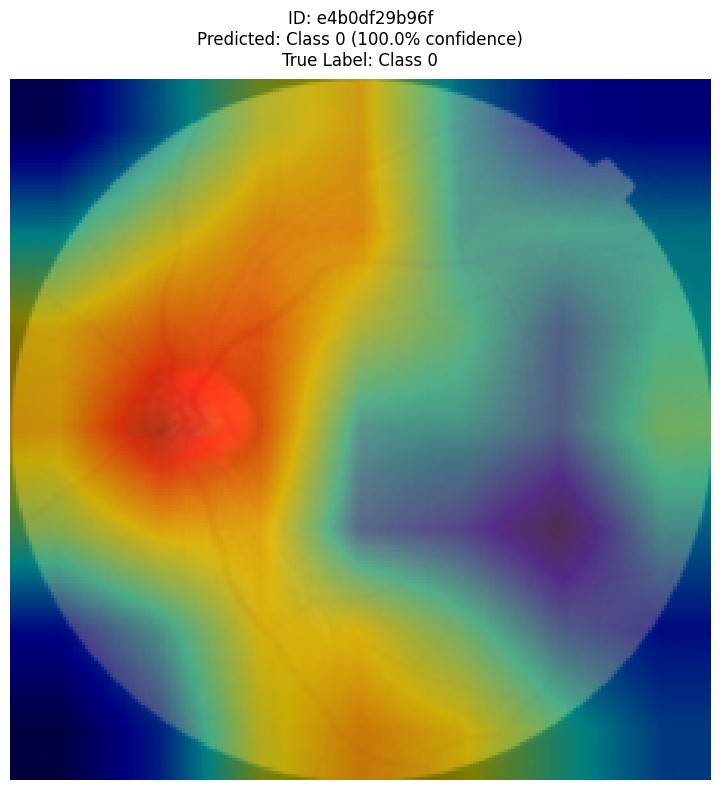

 Generated visualization 1/4


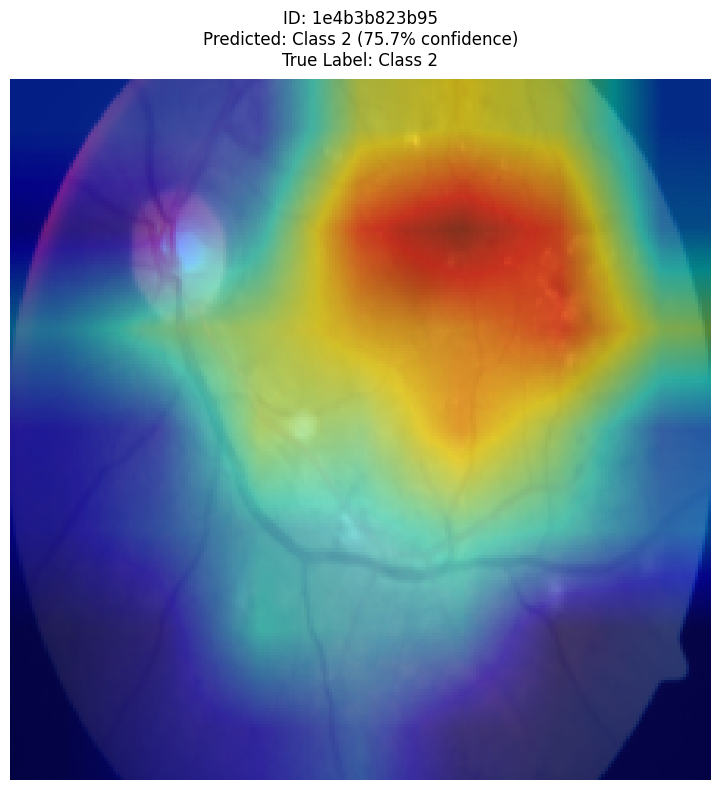

 Generated visualization 2/4


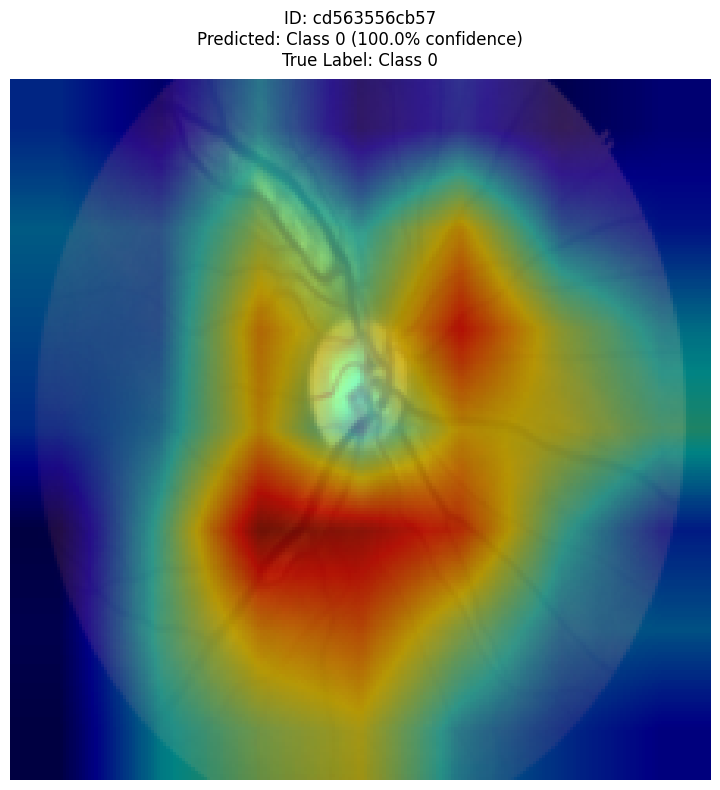

 Generated visualization 3/4


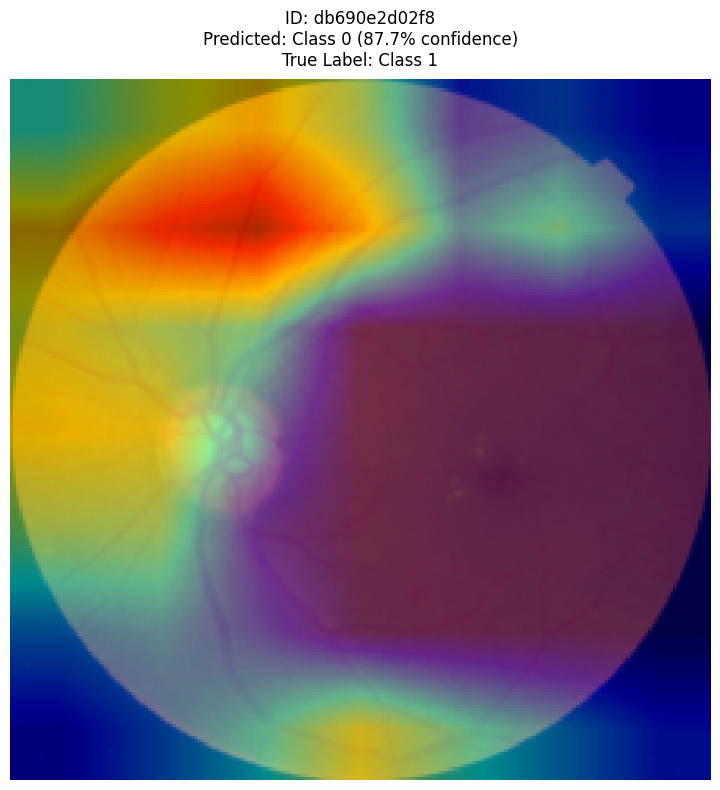

 Generated visualization 4/4

Generated 4 Grad-CAM visualizations!


In [33]:
# Grad-CAM Visualization

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from pathlib import Path
from PIL import Image
import gc

print("🧹 Clearing GPU memory...")

# Force garbage collection
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

#  Simplified Grad-CAM Wrapper
class GradCAMWrapper(nn.Module):
    """Minimal wrapper for Grad-CAM with two inputs"""
    def __init__(self, model, pixel_values):
        super().__init__()
        self.model = model
        self.pixel_values = pixel_values

    def forward(self, x_cnn):
        logits, _, _ = self.model(x_cnn, self.pixel_values)
        return logits

# Process Images One at a Time
print("\n Generating Grad-CAM visualizations...\n")
# Set model to eval mode
model.eval()
# Choose target layer
target_layer = model.cnn.features[-1]
# Reduced image size to save memory
img_size = 224  # Much smaller than training size (512)
# Simple transform for Grad-CAM
gradcam_transform = T.Compose([
    T.Resize((img_size, img_size)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Number of visualizations
n_vis = 4
# Process images one by one
viz_count = 0
for idx in range(len(val_df)):
    if viz_count >= n_vis:
        break
    try:
        # Get image info
        img_id = val_df.iloc[idx]['id_code']
        true_label = int(val_df.iloc[idx]['diagnosis'])

        # Find image path
        img_path = None
        for img_dir in IMAGE_DIRS:
            for ext in ['png', 'jpg', 'jpeg']:
                p = Path(img_dir) / f"{img_id}.{ext}"
                if p.exists():
                    img_path = p
                    break
            if img_path:
                break
        if not img_path:
            print(f" Image {img_id} not found, skipping...")
            continue

        # Load image
        pil_img = Image.open(img_path).convert('RGB')
        # Apply transform
        img_tensor = gradcam_transform(pil_img).unsqueeze(0).to(device)
        # Process for CLIP
        clip_inputs = clip_processor(images=pil_img, return_tensors='pt')
        pixel_values = clip_inputs['pixel_values'].to(device)
        # Get prediction
        with torch.no_grad():
            logits, _, _ = model(img_tensor, pixel_values)
            probs = torch.softmax(logits, dim=1)
            pred_label = torch.argmax(probs, dim=1).item()
            confidence = probs[0, pred_label].item()
        # Create wrapper
        wrapper = GradCAMWrapper(model, pixel_values)
        # Generate Grad-CAM
        cam = GradCAM(model=wrapper, target_layers=[target_layer])
        grayscale_cam = cam(
            input_tensor=img_tensor,
            targets=[ClassifierOutputTarget(pred_label)]
        )[0]
        # Prepare image for visualization (denormalize)
        img_np = img_tensor[0].cpu().numpy().transpose(1, 2, 0)
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)
        # Overlay heatmap
        visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
        # Display
        plt.figure(figsize=(8, 8))
        plt.title(
            f'ID: {img_id}\n'
            f'Predicted: Class {pred_label} ({confidence:.1%} confidence)\n'
            f'True Label: Class {true_label}',
            fontsize=12,
            pad=10
        )
        plt.imshow(visualization)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        viz_count += 1
        print(f" Generated visualization {viz_count}/{n_vis}")
        # CRITICAL: Clean up after EACH image
        del img_tensor, pixel_values, logits, probs
        del wrapper, cam, grayscale_cam, img_np, visualization, pil_img
        gc.collect()
        torch.cuda.empty_cache()

    except Exception as e:
        print(f" Error processing image {idx}: {e}")
        # Clean up on error
        gc.collect()
        torch.cuda.empty_cache()
        continue

print("\n" + "="*60)
print(f"Generated {viz_count} Grad-CAM visualizations!")
print("="*60)

gc.collect()
torch.cuda.empty_cache()

This cell saves the state dictionary of the final fine-tuned model to a file named `clip_densenet_fusion_final.pth`. This allows you to load the trained model later for inference or further analysis.

In [34]:
# Save the final trained model
torch.save(model.state_dict(), 'clip_densenet_fusion_final.pth')
print('Saved final model to clip_densenet_fusion_final.pth')

Saved final model to clip_densenet_fusion_final.pth
